This demo demonstrates Cupy integration with tomosipo. 

It requires the following dependecies:

```
conda install cupy cudatoolkit=X.X  astra-toolbox matplotlib tqdm -c astra-toolbox/label/dev  -c conda-forge
pip install git+https://github.com/ahendriksen/tomosipo.git@WIP-multi-gpu
```



In [28]:
import cupy
import tomosipo as ts
import astra
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

def plot_imgs(width=None, vmin=None, vmax=None, **kwargs):
    if width is None:
        width = plt.rcParams["figure.figsize"][0]

    rows, cols = 1, len(kwargs)
    fig = plt.figure(figsize=(width, rows / cols * width))

    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols))

    for ax, (label, img) in zip(grid, kwargs.items()):
        # Remove ticks, splines
        ax.set_xticks([])
        ax.set_yticks([])
        for s in ax.spines.values():
            s.set_visible(False)

        ax.set_title(label)
        ax.imshow(cupy.asnumpy(img), cmap="gray", vmin=vmin, vmax=vmax)

In [31]:
# import cupy support
import tomosipo.cupy

vg = ts.volume(128)
vd = ts.phantom.hollow_box(ts.data(vg)).data # as numpy array
vd = cupy.asarray(vd) # convert to cupy array

pg = ts.parallel(angles=180, shape=128)
A = ts.operator(vg, pg)
sino = A(vd) # returns a cupy array
bp = A.T(sino)

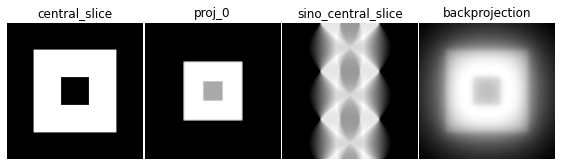

In [32]:
plot_imgs(
    central_slice=vd[64],
    proj_0=sino[:, 0, :],
    sino_central_slice=sino[64],
    backprojection=bp[64],
    width=10,
)


In [34]:
# Test on different devices:
num_cuda_devices = 1

# recreate the volume on each device:
vds = []
for i in range(num_cuda_devices):
    with cupy.cuda.Device(i):
        vds.append(vd.copy())
    
# compute sinogram on each device    
sinos = [A(vd) for vd in vds]

# crudely check that everything went alright:
for vd, s in zip(vds, sinos):
    with vd.device:
        print("volume: ", vd.device, vd.mean(), vd.max(), vd.min())
        print("sino:   ", s.device, s.mean(), s.max(), s.min())


volume: <CUDA Device 0>
volume:  <CUDA Device 0> 0.21790314 1.0 0.0
sino:    <CUDA Device 0> 0.109146185 0.8471311 0.0
